In [ ]:
# TODO: take a quick look at 
# experiments/germline-model/chen-et-al-2022/simulate_dataset.py
# to see if Tom has already implemented the functionality that I describe below. 

# TODO: generalize intersect-windows-with-topmed-deletions.sh so that it takes an additional input (a bed file of deletions), and it pushes an appropriately named bed file to the public repo 
# 1.1 the observed statistics are computed as before using the topmed deletions (namely from {gene_class}-canonical-exons-intersect-deletions.bed)
# 1.2 write a bash function called get-observed-deletions that streams the topmed deletions and pass that function as a process-substitution argument to intersect-windows-with-topmed-deletions.sh
# 2.1 the null statistics are computed using shuffled versions of the topmed deletions
# 2.2 write a bash function called get-shuffled-deletions that shuffles the topmed deletions and pass that function as a process-substitution argument to intersect-windows-with-topmed-deletions.sh
# 2.3 get-shuffled-deletions: bedtools shuffle -i <(get-observed-deletions) -g my.genome -excl <(get-exclude-regions) 
# 3. wrap the python code that calls intersect-windows-with-topmed-deletions.sh in a function 
#    that takes as argument get-deletions,
#    returns the fraction of negative genes that have no overlapping deletion, 
#    and then call the function 1 time with get-deletions==get-observed-deletions to get the observed fraction,
#    and 1000 times with get-deletions==get-shuffled-deletions to get the null distribution of fractions
# 4. plot the distribution of fractions under the null, together with the observed fraction
# 5. compute the p-value as the fraction of null fractions that are greater than the observed fraction
# 6. do all the above for gene-class==negative (expecting the pvalue to be insignificant) and gene-class==positive (expecting the pvalue to be significant)

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

LOWER_DELETION_SIZE_LIMIT = 4000
UPPER_DELETION_SIZE_LIMIT = 10000
DELETION_ALLELE_FREQ_THRESHOLD = 0.00001

# DELETION_TYPE = 'long' 
DELETION_TYPE = 'all' 

BALANCE_CLASSES = False

PUBLIC_REPO = 'constraint-tools-data'
PUBLIC_REPO_DIR = f'/scratch/ucgd/lustre-work/quinlan/u6018199/{PUBLIC_REPO}'
PROCESSED_DELETIONS = f'{DELETION_TYPE}-deletions.bed'

## The depletion of genetic variation is expected to be more pronounced in coding sequence than in intronic sequence 

Tom has shown that deletion deserts are enriched for coding sequence over genic sequence (coding sequence plus intronic sequence, etc), 
and that this enrichment becomes more pronounced as the expected degree of negative selection increases. 

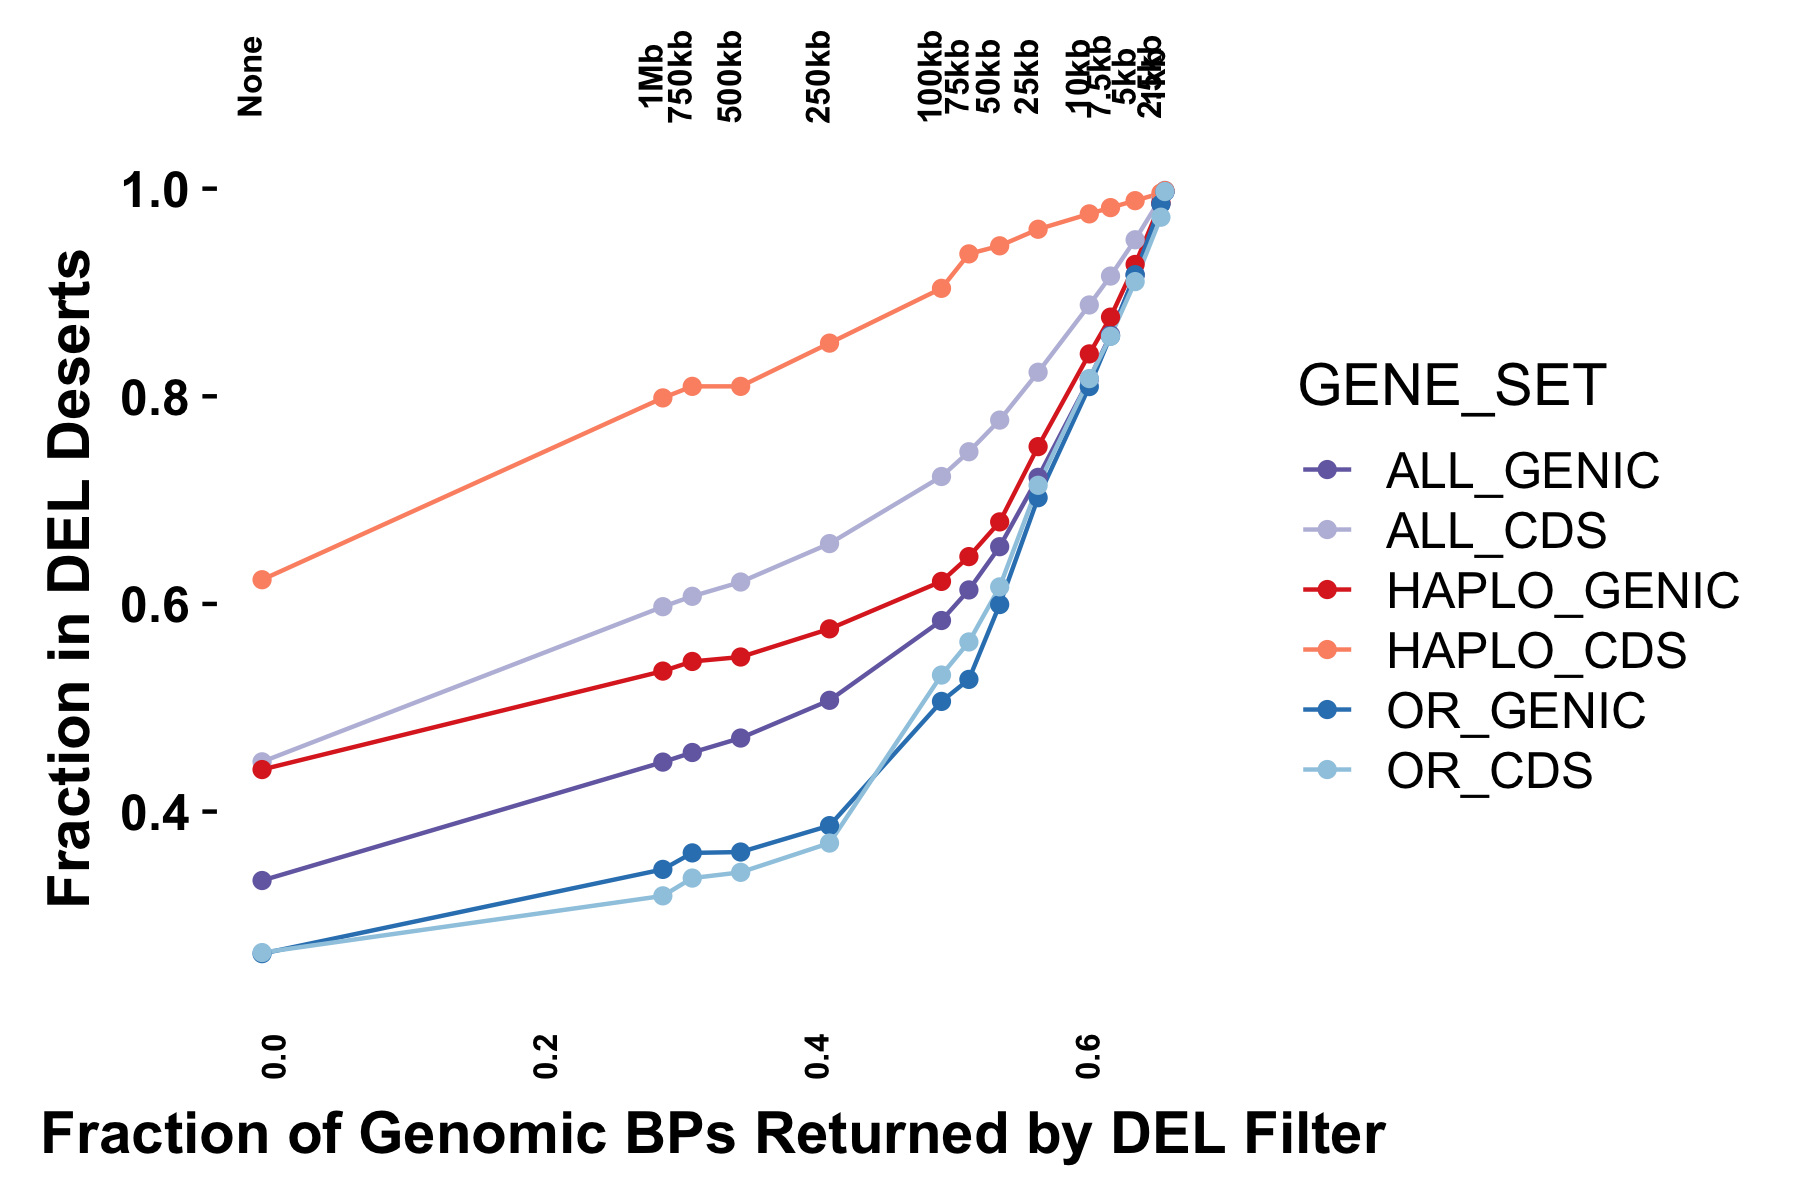

In [2]:
from IPython.display import Image # type: ignore

# Display the image in the Jupyter Notebook cell
Image(filename='fraction_in_DEL_deserts.png', width=800)

## Compute SNV scores of a set of positive and negative genes (i.e. genes that are known to be under negative selection or no selection) by using ONLY the exons of these genes


In [3]:
import pandas as pd
import numpy as np

from shell import shell 
from colorize import print_string_as_info
from aggregate import aggregate

def get_header(filename):
  with open(filename) as fh: 
    header = fh.readline().strip().split('\t')
  return header

def intersect(a_filename, b_filename, intersect_filename): 
  cmd = (
    f'bedtools intersect'
    f" -a <(tail -n +2 {a_filename})" 
    f" -b <(tail -n +2 {b_filename})"
    f' -wao -f 0.5'
    f' > {intersect_filename}'
  )
  shell(cmd)
  print_string_as_info(f'Wrote {intersect_filename}')

  a_file_header = get_header(a_filename)
  b_file_header = get_header(b_filename)

  return a_file_header, b_file_header

def set_column_dtypes(df, column_dtypes, log=False): 
  for col, dtype in column_dtypes.items(): 
    df[col] = df[col].astype(dtype)

  if log: print(dict(df.dtypes))
  return df 

def make_SNV_score_numeric(df): 
  # we don't want to include exons that don't overlap any Chen windows
  df = df[df['chrom'] != '.'] 

  # having removed records where 'negative new chen zscore' is '.', we can now convert the column to a float
  df = set_column_dtypes(
    df,   
    column_dtypes = {
      'negative new chen zscore': float,
    }
  )

  return df 
  
def assign_SNV_scores_to_labeled_genes(gene_class):
  a_filename = f'{CONSTRAINT_TOOLS_DATA}/genes/grch38/canonical-exons.{gene_class}.sorted.bed'
  b_filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/small-windows.bed'
  intersect_filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/{gene_class}-canonical-exons-intersect-chen-windows.bed'

  a_file_header, b_file_header = intersect(a_filename, b_filename, intersect_filename)

  df = pd.read_csv(
    intersect_filename, 
    sep='\t',
    names=a_file_header + b_file_header + ['exon_chen_overlap'],
  )

  df = df[
    (df['chromosome'] != 'chrX') &
    (df['chromosome'] != 'chrY')
  ]

  df = make_SNV_score_numeric(df)
  
  # though unlikely, some exons may intersect multiple Chen windows, 
  # so let's group by exon, and compute the min Chen score over all Chen windows in the group
  df = aggregate(
    df, 
    group_columns = a_file_header,
    aggregation_functions = {
      'negative new chen zscore': [np.min],
    }
  )

  # group exons by parent gene, computing min z-score in each group
  df = aggregate(
    df, 
    group_columns = ['gene_symbol'],
    aggregation_functions = {
      'min negative new chen zscore': [np.min],
    }
  )

  # [TODO] possibly normalize by number of exons in each gene (this would make sense if the aggregate were a mean, but it's a min, so maybe not)

  df = df.rename(columns={
    'min min negative new chen zscore': 'min negative new chen zscore over all exons'
  })

  return df 

assign_SNV_scores_to_labeled_genes(gene_class='negative')

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/negative-canonical-exons-intersect-chen-windows.bed
<ipython-input-3-de7c68da8dc5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(dtype)


,gene_symbol,min negative new chen zscore over all exons
0,OR10A3,-0.817755
1,OR10A4,1.320257
2,OR10A5,-0.349816
3,OR10A6,2.569226
4,OR10AD1,0.050568
...,...,...
263,OR9G4,3.281551
264,OR9I1,0.853197
265,OR9K2,3.569851
266,OR9Q1,-0.223640


## Compute SV scores of a set of positive and negative genes (i.e. genes that are known to be under negative selection or no selection) by using ONLY the exons of these genes


In [4]:
def assign_SV_scores_to_labeled_genes(
    gene_class, 
    get_topmed_deletions_tail=f'get-{DELETION_TYPE}-topmed-deletions-tail', 
    deletion_type=DELETION_TYPE
):
  windows = f'{CONSTRAINT_TOOLS_DATA}/genes/grch38/canonical-exons.{gene_class}.sorted.bed'
  windows_with_deletions = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/{gene_class}-canonical-exons-intersect-deletions.bed'

  intersect_script = f'{CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/intersect-windows-with-topmed-deletions.sh'

  cmd = (
    f'bash '
    f'{intersect_script} '
    f'{windows} {windows_with_deletions} {PUBLIC_REPO_DIR} {PROCESSED_DELETIONS} '
    f'{get_topmed_deletions_tail} {deletion_type} '
    f'{LOWER_DELETION_SIZE_LIMIT} {UPPER_DELETION_SIZE_LIMIT} {DELETION_ALLELE_FREQ_THRESHOLD}'
  )
  print(shell(cmd))

  df = pd.read_csv(
    windows_with_deletions, 
    sep='\t',
  )

  df = df[
    (df['chromosome'] != 'chrX') &
    (df['chromosome'] != 'chrY')
  ]

  # though unlikely, some exons may intersect multiple merged (and therefore non-overlapping) deletions,
  # therefore group by exon (and deletion count), and compute "sum deletion overlap" in each group,
  group_columns = df.columns.tolist()
  group_columns.remove('deletion_overlap')
  df = aggregate(
    df, 
    group_columns = group_columns,
    aggregation_functions = {
      'deletion_overlap': [np.sum],
    }
  )

  df['exon_length'] = df['exon_end'] - df['exon_start']

  # group exons by parent gene, 
  # computing "sum deletion count" and "sum deletion overlap" in each group, 
  df = aggregate(
    df, 
    group_columns = ['chromosome', 'gene_symbol'],
    aggregation_functions = {
      'exon_start': [np.min],
      'exon_end': [np.max],
      'exon_rank': 'count',
      'deletion_count': [np.sum],
      'sum deletion_overlap': [np.sum],
      'exon_length': [np.sum],
    }
  )

  df['gene coordinates'] = df['chromosome'] + ':' + df['min exon_start'].astype(str) + '-' + df['max exon_end'].astype(str)
  df = df.drop(columns=['chromosome', 'min exon_start', 'max exon_end'])
  df['deletion count per bp'] = df['sum deletion_count'] / df['sum exon_length']
  df['fraction of bps that are deleted'] = df['sum sum deletion_overlap'] / df['sum exon_length']

  df = df.rename(columns={
    'count exon_rank': 'exon_count',
    'sum deletion_count': 'deletion count over all exons',
    'sum sum deletion_overlap': 'deletion overlap over all exons',
    'sum exon_length': 'total length of all exons',
  })

  return df

assign_SV_scores_to_labeled_genes(gene_class='positive')

We assume that the first line of the following is a header line: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/genes/grch38/canonical-exons.positive.sorted.bed
Wrote windows with deletion counts and overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/positive-canonical-exons-intersect-deletions.bed
Wrote number of deletions in this particular stratum to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/number-all-deletions.txt
Wrote deletions in UCSC-genome-browser format for this particular stratum to: /scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools-data/all-deletions.bed
Everything up-to-date
Pushed /scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools-data/all-deletions.bed to public repo
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


,gene_symbol,exon_count,deletion count over all exons,deletion overlap over all exons,total length of all exons,gene coordinates,deletion count per bp,fraction of bps that are deleted
0,ACTN2,21,3,407,4851,chr1:236686499-236764631,0.000618,0.083900
1,ADAR,15,0,0,6595,chr1:154582057-154608186,0.000000,0.000000
2,AHDC1,7,0,0,6431,chr1:27534303-27603632,0.000000,0.000000
3,AMPD1,16,6,866,2359,chr1:114673098-114695586,0.002543,0.367105
4,APOA2,4,0,0,470,chr1:161222292-161223628,0.000000,0.000000
...,...,...,...,...,...,...,...,...
641,TGFBR1,9,4,869,5924,chr9:99105150-99153658,0.000675,0.146691
642,TOR1A,5,0,0,2075,chr9:129812942-129824136,0.000000,0.000000
643,TPM2,9,10,1318,1318,chr9:35682926-35690056,0.007587,1.000000
644,TSC1,23,6,3792,8593,chr9:132891348-132944633,0.000698,0.441289


## Combine SNV and SV scores of positive and negative genes 


In [5]:
def create_examples(gene_class): 
  df = pd.merge(
    assign_SNV_scores_to_labeled_genes(gene_class),
    assign_SV_scores_to_labeled_genes(gene_class),
    on='gene_symbol',
    how='inner',
  )
  df['truly constrained'] = gene_class == 'positive'
  return df

def concat(dfs): 
  df = pd.concat(dfs)
  df = df.reset_index(drop=True) # drop duplicates in index so that later index-based operations are possible 
  return df

def label_examples(): 
  negative_examples = create_examples(gene_class='negative')
  positive_examples = create_examples(gene_class='positive')

  if BALANCE_CLASSES: # balance classes for later training 
    positive_examples = positive_examples.sample(n=len(negative_examples), random_state=0) 

  df = concat([negative_examples, positive_examples])

  return df 

LABELED_EXAMPLES = label_examples()
LABELED_EXAMPLES

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/negative-canonical-exons-intersect-chen-windows.bed
<ipython-input-3-de7c68da8dc5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(dtype)


We assume that the first line of the following is a header line: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/genes/grch38/canonical-exons.negative.sorted.bed
Wrote windows with deletion counts and overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/negative-canonical-exons-intersect-deletions.bed
Wrote number of deletions in this particular stratum to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/number-all-deletions.txt
Wrote deletions in UCSC-genome-browser format for this particular stratum to: /scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools-data/all-deletions.bed
Everything up-to-date
Pushed /scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools-data/all-deletions.bed to public repo
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean



Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/positive-canonical-exons-intersect-chen-windows.bed


We assume that the first line of the following is a header line: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/genes/grch38/canonical-exons.positive.sorted.bed
Wrote windows with deletion counts and overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/positive-canonical-exons-intersect-deletions.bed
Wrote number of deletions in this particular stratum to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/number-all-deletions.txt
Wrote deletions in UCSC-genome-browser format for this particular stratum to: /scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools-data/all-deletions.bed
Everything up-to-date
Pushed /scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools-data/all-deletions.bed to public repo
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


,gene_symbol,min negative new chen zscore over all exons,exon_count,deletion count over all exons,deletion overlap over all exons,total length of all exons,gene coordinates,deletion count per bp,fraction of bps that are deleted,truly constrained
0,OR10A3,-0.817755,2,3,2648,2648,chr11:7937171-7941708,0.001133,1.0,False
1,OR10A4,1.320257,1,4,994,994,chr11:6876625-6877619,0.004024,1.0,False
2,OR10A5,-0.349816,1,4,1053,1053,chr11:6845652-6846705,0.003799,1.0,False
3,OR10A6,2.569226,4,6,6100,6100,chr11:7924592-7931268,0.000984,1.0,False
4,OR10AD1,0.050568,1,1,1304,1304,chr12:48202083-48203387,0.000767,1.0,False
...,...,...,...,...,...,...,...,...,...,...
838,ZEB1,-2.916458,9,0,0,5981,chr10:31319172-31529813,0.000000,0.0,True
839,ZEB2,-5.563620,10,0,0,9255,chr2:144384081-144520119,0.000000,0.0,True
840,ZFPM2,-1.773814,8,0,0,4953,chr8:105318438-105804539,0.000000,0.0,True
841,ZFYVE27,-3.042094,13,14,3032,3032,chr10:97737128-97760895,0.004617,1.0,True


## Plot the distribution of SNV and SV scores of positive and negative genes

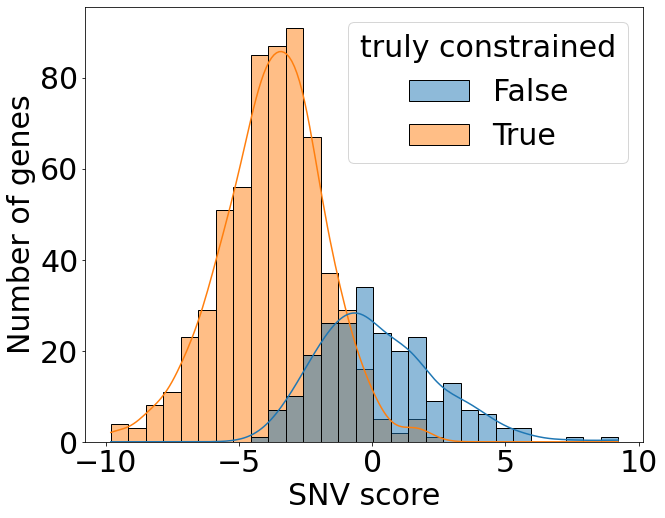

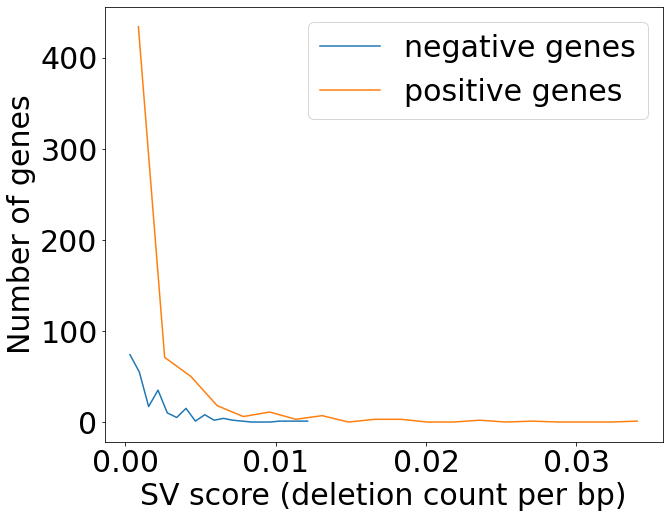

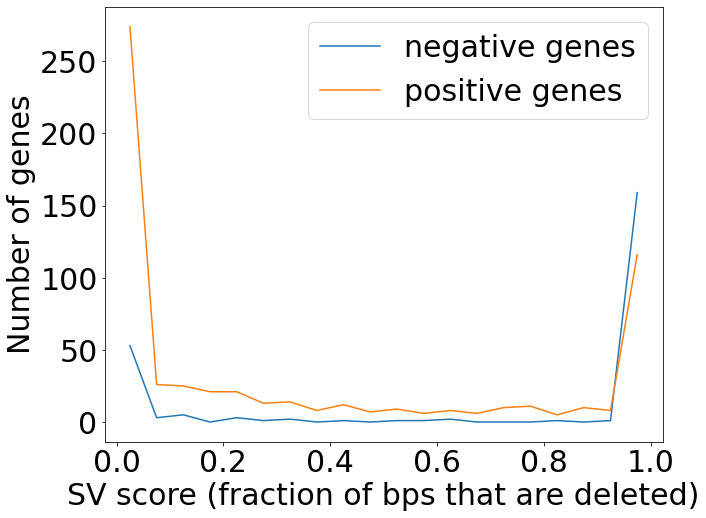

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size
mpl.rcParams['font.size'] = 30
plt.rcParams['figure.figsize'] = (10, 8)

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.histplot(data=LABELED_EXAMPLES, x='min negative new chen zscore over all exons', hue='truly constrained', kde=True)
plt.xlabel('SNV score')
plt.ylabel('Number of genes')
plt.show()

def plot_distribution(ser, label): 
  counts, edges = np.histogram(ser, bins=20)
  total_count = np.sum(counts)
  centers = (edges[:-1] + edges[1:]) / 2
  # plt.plot(centers, counts/total_count, label=label, alpha=1)
  plt.plot(centers, counts, label=label, alpha=1)

def filter_scores_on_constraint(df, constrained, score): 
  df = df[df['truly constrained'] == constrained]
  ser = df[score]
  return ser

def plot_distributions(df, score, score_alias):
  plot_distribution(filter_scores_on_constraint(df, constrained=False, score=score), label='negative genes')
  plot_distribution(filter_scores_on_constraint(df, constrained=True, score=score), label='positive genes')
  plt.legend()
  plt.xlabel(score_alias)
  # plt.ylabel('Fraction of genes')
  plt.ylabel('Number of genes')
  plt.show()

plot_distributions(
  LABELED_EXAMPLES, 
  score='deletion count per bp',
  score_alias='SV score (deletion count per bp)'
)

plot_distributions(
  LABELED_EXAMPLES, 
  score='fraction of bps that are deleted',
  score_alias='SV score (fraction of bps that are deleted)'
)